# Exercise: Steering computer programs
For many tasks, computer programs are already available to help you solve a problem. Sometimes, however, you might have to run the program many times with different input, which means that user input would have to be changed manually each time. For example, you may want to run a radiative transfer model to calculate the radiance at a sensor for each pixel in the satellite image. This satellite image could consist of millions of pixels! It should be more efficient to write a code to automatize the process.

**Teaching goals:**
1. You learn how to control an external program with Python using the `subprocess` module. 
2. You learn how to use `xarray` to create netCDF files for your simulations that include metadata. 

## Solar irradiance spectrum
In this exercise, you will recreate the plot below showing solar irradiance at the top of the atmosphere (yellow curve) and at sea level (red curve).

![Spectrum of solar radiation at Earth](images/500px-Solar_spectrum_en.svg.png "Spectrum of solar radiation at Earth")

### Top of the atmosphere irradiance

A solar reference spectrum with the top of the atmosphere irradiance can be found in the following file: `data/kurudz_1.0nm.dat`. 

**Task**: 
1. Write a code that reads wavelengths and irradiances from the solar reference file.
1. Create a `xarray.Dataset` to store wavelengths and irradiances with some attributes (e.g. 'standard_name' and 'units').
1. Make a plot with labels and legend that shows the solar spectrum between 250 and 2500 nm.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

wavelength, irradiance = np.loadtxt("data/kurudz_1.0nm.dat", unpack=True)


In [2]:
#xarray Dataset für wavelength:
import xarray

attrs = {"long name": "wavelength","unit":"nm"}
wavelength = xarray.DataArray(
    data=wavelength,
    name='wavelength',
    dims=('wavelength',),
    attrs=attrs
)
wavelength

#xarray Dataset für irradiance, wavelength als Koordinaten:

attrs = {
    'long_name': 'spectral irradiance',
    'units': 'mW m-2 nm-1',
    'reference': (
        'Kurucz, R.L., Synthetic infrared spectra, in Infrared Solar Physics, IAU Symp. 154, '
        'edited by D.M. Rabin and J.T. Jefferies, Kluwer, Acad., Norwell, MA, 1992.')
}
coords = {
    'wavelength': wavelength
}

irradiance = xarray.DataArray(
    data=irradiance,
    name='irradiance',
    dims=('wavelength',),
    coords=coords,
    attrs=attrs
)
irradiance

<xarray.DataArray 'irradiance' (wavelength: 9751)>
array([63.52968  , 43.95971  , 29.09898  , ...,  0.2441999,  0.2441391,
        0.243612 ])
Coordinates:
  * wavelength  (wavelength) float64 250.0 251.0 252.0 ... 9.999e+03 1e+04
Attributes:
    long_name:  spectral irradiance
    units:      mW m-2 nm-1
    reference:  Kurucz, R.L., Synthetic infrared spectra, in Infrared Solar P...

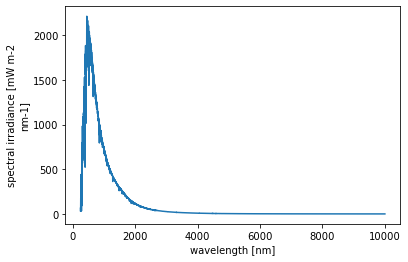

In [3]:
irradiance.plot()

### At surface irradiance

To compute the irradiance at the surface, you will use the libRadtran radiative transfer model (www.libradtran.org). libRadtran will compute the irradiance by accounting Rayleigh and Mie scattering as well as absorption of atmospheric trace gases and aerosols at different wavelengths.

The standard way to use libRadtran is calling the *uvspec* command from a Linux Terminal. `uvspec` reads commands from an input file (e.g. *uvspec.inp*) needed for computing spectra. A simple *uvspec.inp* file for computing irradiance at the surface is the following:
```
data_files_path /tmp/data/

source solar /tmp/data/solar_flux/kurudz_1.0nm.dat
atmosphere_file /tmp/data/atmmod/afglus.dat

wavelength 250 2500
zout 0.0

output_user wavelength edir
```

To run *uvspec* from the Linux Terminal, open a terminal window with Jupyter: `File -> New -> Terminal`. In the terminal, change the directory to directory where the *uvspec.inp* file is located (see hint in box) and type the following command:  
```bash
uvspec < uvspec.inp > uvspec.out
```
This will execute *uvspec*, which will read input from the *uvspec.inp* file and write output the *uvspec.out* file, which contains the irradiance spectrum at the surface.

<div class="alert alert-warning">
    <b>Hint:</b> To navigate in a Linux shell, you can use the following two commands:
<ul>
    <li><i>ls</i>: list information about the files in the current directory.</li>
    <li><i>cd DIR</i>: change the shell working directory to *DIR*.</li>
</ul>
</div>

Next, you need to add the spectrum to your plot: Write Python code to read *uvspec.out*, store it in an `xarray.Dataset`, and plot it together with the top of the atmosphere spectrum. 

In [4]:
uvspec_wavelen= []
uvspec_irradiance = []
uvspec_wavelen, uvspec_irradiance = np.loadtxt("uvspec.out", unpack = True)

#Xarray Dataset:

#xarray Dataset für wavelength:

attrs = {"long name": "wavelength","unit":"nm"}
uvspec_wavelen = xarray.DataArray(
    data=uvspec_wavelen,
    name='wavelength',
    dims=('wavelength',),
    attrs=attrs
)
wavelength

#xarray Dataset für irradiance, wavelength als Koordinaten:

attrs = {
    'long_name': 'spectral irradiance at surface',
    'units': 'mW m-2 nm-1',
    'reference': (
        'Kurucz, R.L., Synthetic infrared spectra, in Infrared Solar Physics, IAU Symp. 154, '
        'edited by D.M. Rabin and J.T. Jefferies, Kluwer, Acad., Norwell, MA, 1992.')
}
coords = {
    'wavelength': uvspec_wavelen
}

uvspec_irradiance = xarray.DataArray(
    data=uvspec_irradiance,
    name='irradiance',
    dims=('wavelength',),
    coords=coords,
    attrs=attrs
)
uvspec_irradiance

<xarray.DataArray 'irradiance' (wavelength: 2251)>
array([0.      , 0.      , 0.      , ..., 8.038083, 8.074684, 8.043993])
Coordinates:
  * wavelength  (wavelength) float64 250.0 251.0 252.0 ... 2.499e+03 2.5e+03
Attributes:
    long_name:  spectral irradiance at surface
    units:      mW m-2 nm-1
    reference:  Kurucz, R.L., Synthetic infrared spectra, in Infrared Solar P...

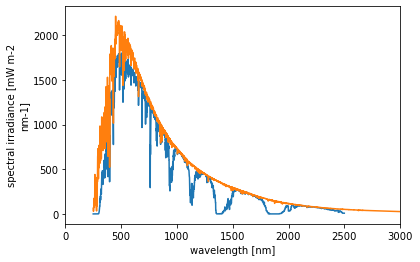

In [13]:
uvspec_irradiance.plot(xlim= (0,3000))
irradiance.plot(xlim= (0,3000))


### Calling *uvspec* with Python

Instead of running *uvspec* in the terminal, you can also run the command directly in Python using the `run` function that is part of the `subprocess` module.

The following examples, calls *uvspec*, which reads input from a string `input`: 
```python
import subprocess
process = subprocess.run('uvspec', input=input, capture_output=True, encoding='utf-8')
```
The `subprocess.run` function returns a `CompletedProcess` object that has the follwing attributes:
- `args`: The arguments for the external program (here: *uvspec*).
- `returncode`: The return code of your program, which should be 0 if the program finished normally.
- `stdout`: The output from *uvspec* previously written to the *uvspec.out* file.
- `stderr`: Any info or error messages from *uvspec*.


**Task**: Write a code that runs *uvspec* with the input from *uvspec.inp*. Parse the output (`process.stdout`) and create an `xarray.Dataset` containing wavelengths and irradiance. Add the spectrum to your plot.

In [62]:
import subprocess

#load uvspec.inp (?)

with open("uvspec.inp") as uvspec_inputfile:
    uvspec_inp = uvspec_inputfile.read()
process = subprocess.run('uvspec', input=uvspec_inp, capture_output=True, encoding='utf-8')

list1 = process.stdout.splitlines()
output_wavelen = []
output_irradiance =[]
for i in list1:
    split = i.split()
    output_wavelen.append(float(split[0].strip()))
    output_irradiance.append(float(split[1].strip()))

output_wavelen = np.array(output_wavelen)


In [65]:
#Xarray Dataset:

#xarray Dataset für wavelength:

attrs = {"long name": "wavelength","unit":"nm"}
output_wavelen = xarray.DataArray(
    data=output_wavelen,
    name='wavelength',
    dims=('wavelength',),
    attrs=attrs
)

#xarray Dataset für irradiance, wavelength als Koordinaten:

attrs = {
    'long_name': 'spectral irradiance at surface',
    'units': 'mW m-2 nm-1',
    'reference': (
        'Kurucz, R.L., Synthetic infrared spectra, in Infrared Solar Physics, IAU Symp. 154, '
        'edited by D.M. Rabin and J.T. Jefferies, Kluwer, Acad., Norwell, MA, 1992.')
}
coords = {
    'wavelength': output_wavelen
}

output_irradiance = xarray.DataArray(
    data=output_irradiance,
    name='irradiance',
    dims=('wavelength',),
    coords=coords,
    attrs=attrs
)

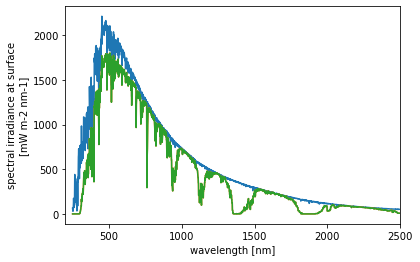

In [74]:
irradiance.plot(xlim= (200,2500))
uvspec_irradiance.plot(xlim= (200,2500))
output_irradiance.plot(xlim= (200,2500))

### Optional: Black-body radiation

##### The figure you are re-creating also includes the black-body irradiance spectrum at 5778 Kelvin. The black-body irradiance is described by Planck's law:
\begin{equation}
B(\lambda, T) =\frac{2hc^2}{\lambda^5}\frac{1}{ e^{\frac{hc}{\lambda k T}} - 1}
\end{equation}
with radiance $B$ (in W m$^{-3}$ sr$^{-1}$), temperature $T$ (in K), Planck's constant $h$ (in J s), speed of light $c$ (in m/s), wavelength $\lambda$ (in m) and Boltzmann constant $k$ (J/K). Since Planck's law calculates radiances, you need to convert to irradiance by multiplying it with the solid angle of the sun in the sky (i.e. 6.807x10$^{−5}$ sr).  

**Task**: 
- Write a Python function that computes the black-body radiation for given 5778 K for wavelengths from 250 to 2500 nm.
- Note that physical constants are defined in the `scipy.constants` module. 
- Add a line to your plot for black-body irradiance spectrum.

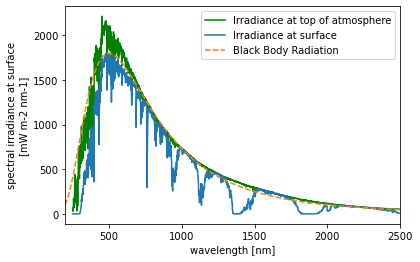

In [159]:
import scipy.constants as sco
import math

def blackbody(wavelen):
    temp = 5778
    wave = wavelen/1000000000
    first_par= ((2 * sco.h*(sco.c**2))/(wave)**5)
    second_par= (1/(np.exp(((sco.h*sco.c)/((wave)*sco.k*temp)), dtype = np.float128)-1))
    angle = 6.807*(10**(-5))
    
    return first_par* second_par* angle/1000000
blackbody(500)

black= []
for i in range(1,2501):
    black.append(blackbody(i))


irradiance.plot(xlim= (200,2500), color = "green")
uvspec_irradiance.plot(xlim= (200,2500))
plt.plot(black, linestyle = "dashed")

# add labels
#plt.set_xlabel('Wavelength [nm]')
#plt.set_ylabel('Irradiance [mW m-2 nm-1')
#plt.grid(True)
plt.legend(("Irradiance at top of atmosphere", "Irradiance at surface", "Black Body Radiation"))

### Optional: Text, annoations, etc.
You can further practice using matplotlib by adding the missing text, arrows and lines to your figure using `plt.text`, `plt.annotate`, `plt.vlines`.

## Langley extrapolation

To compute the irradiance at sea level, we actually need to know the irradiance spectrum outside the atmosphere. How we can actually know this since the 18th century without spacecraft?

Langley extrapolation is a method for determining the Sun's irradiance at the top of the atmosphere with ground-based instrumentation (https://en.wikipedia.org/wiki/Langley_extrapolation). For a Langley extrapolation, we measure the solar irradiance at different solar zenith angles $\theta$. The irradiance at the surface can be written by Lambert-Beer's law as:

$E = E_0 \, exp(-m \tau)$

with $E$ and $E_0$ being the irradiance at the surface and outside of the atmosphere, respectively. $\tau$ is the optical depth of the atmosphere. $m$ is the air mass factor that accounts for the slant optical path. The air mass factor depends on the solar zenith angle:

$m = \frac{1}{cos(\theta)}$

<img src=images/air-mass-factor.png />

If we take the natural logarithm (`np.log`) of the Lambert-Beer law, we can write:

$ln(E) = ln(E_0) - m \tau$

We can see that if we measure $ln(E)$ for different air mass factors, i.e. for different solar zenith angle, we can obtain a scatter plot with $ln(E)$ on the y-axis and $m$ on the x-axis. If we do a linear regression for these points, we can get a line where the slope is $-\tau$ and the intercept $ln(E_0)$. We therefore can compute $E_0$ directly from the intercept. 

**Task**:
- Use *uvspec* to calculate the irradiance at 760 nm for different solar zenith angles (e.g. 0, 10, 20, 30, 40, 50 and 60 degrees). Note that *uvspec* computes irradiance (*edir*) with respect to the horizontal plane. To obtain values with respect to the instrument, irradiances need to be divided by the cosine of the solar zenith angle.
- Instead of writing and reading an input file, you can pass a string of commands directly to `subprocess.run`. Hint: Use `str.format` to replace the solar zenith angle.
- Plot the logarithm of the irradiance against the air mass factor.
- Do a liner regression (`scipy.stats.linregress`) to obtain slope and intercept and use it to compute the solar irradiance at the top of the atmosphere. 
- Compare your result with the irradiance in *kurudz_1.0nm.dat*.
- *Optional*: Apply Langley extrapolation to the full spectral range (250 - 2500 nm).

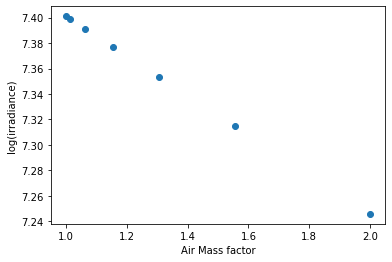

In [210]:
commands = """
data_files_path /tmp/data/

source solar /tmp/data/solar_flux/kurudz_1.0nm.dat
atmosphere_file /tmp/data/atmmod/afglus.dat

wavelength 500
zout 0.0
sza {sza}

output_user wavelength edir
"""

import subprocess
import scipy.stats as sci

#load uvspec.inp (?)

szangle = []
result = []

for i in range(0,70,10):
    process_input = commands.format(sza = i)
    process = subprocess.run('uvspec', input=process_input, capture_output=True, encoding='utf-8')

    irrad = process.stdout.split()
    szangle.append(i)
    result.append(float(irrad[1])/np.cos(np.radians(i)))


massfact = 1/np.cos(np.radians(szangle))

fig, ax = plt.subplots()

ax.scatter(massfact,np.log(result))
ax.set_xlabel('Air Mass factor')
ax.set_ylabel('log(irradiance)')

linregression = sci.linregress(massfact, np.log(result))

In [223]:
print(np.exp(test.intercept))
irradiance.data[250]


1913.0089406741401


1913.283